# Interpolation

Occasionally we need to know the value of a function between data points.

Let's create a mildly complicated function. We'll then sample it poorly, then explore ways to interpolate between those points.

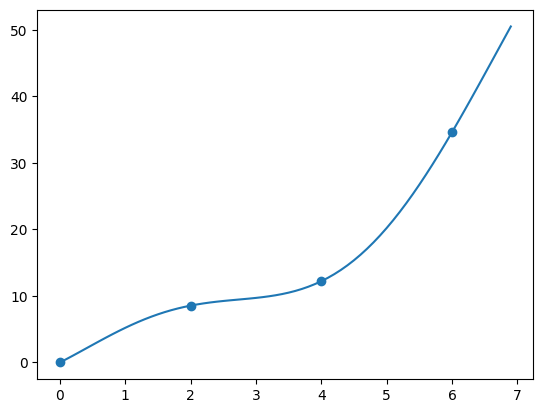

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def exFunc(x):
    return x**2 + 5*np.sin(x)

x_dense = np.arange(0, 7, 0.1)
y_dense = exFunc(x_dense)

x_sparse = np.arange(0, 7, 2)
y_sparse = exFunc(x_sparse)

plt.plot(x_dense, y_dense)
plt.scatter(x_sparse, y_sparse)

The simplest way to interpolate between points is to assume a straight line. As discussed in the textbook, if we only have two points, this is our only option.

Write a function that accepts two (x, y) points and uses linear interpolation to return any value between them. 

## Diversion!!

This is a great place to plunge head first down a rabbit hole. We have so far avoided discussing Python objects because we haven't needed them. But Python is a self-consciously very object-oriented language and it would be a disservice to you to pretend otherwise.

Below we'll define an object called FitFunction (object definitions are often CamelCase by convention), and we'll define a special property of the object `__call__`. This allows the object to be called like a function; such objects are often referred to as "functals".

In [2]:
class FitFunction(object):
    def __init__(self, m=None, b=None):
        self.m = m
        self.b = b
        assert m is not None, "must pass slope (m) to instantiate object"
        assert b is not None, "must pass intercept (b) to instantiate object"

    def __call__(self, x):
        return self.m * x + self.b

example_line = FitFunction(m=2, b=0)
print(example_line(5))
example_line2 = FitFunction()
print(example_line2(5))

10


AssertionError: must pass slope (m) to instantiate object

Notice the `assert` statements. If you've never seen `assert` before, it will cause the code to throw an `AssertionError` and halt if the condition is not satisfied. This is typically used by developers to catch easily made mistakes or edge cases they want to avoid.

We will use this object to help interpolate. Modify the object definition so that is only valid for the range between the points we're going to fit. Then write some code to interpolate between two points; the functal you've written should be helpful. You may also find it useful to remember the point-slope form for a line: $y - y_1 = m(x - x_1)$

Use your code to plot the data series with 10 points between each "sparse" point.

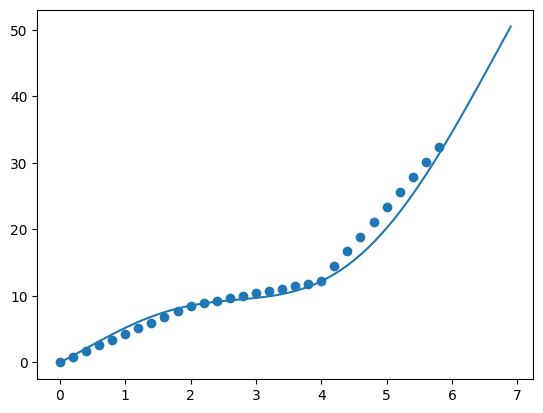

In [8]:
# code

x_linear = np.arange(0, 6, 0.2)
y_linear = np.zeros(len(x_linear))

for i in range(3):
    slope = (y_sparse[i+1] - y_sparse[i])/(x_sparse[i+1] - x_sparse[i])
    fit_line = FitFunction(m=slope, b=(y_sparse[i+1] - slope*x_sparse[i+1]))

    for j in range(10):
        y_linear[j+10*i] = fit_line(x_linear[j+10*i])

plt.plot(x_dense, y_dense)
plt.scatter(x_linear, y_linear)

Fortunately out code has more than two points so we can do better than linear interpolation. 

With 3 points, the equation of the 2nd degree polynomial passing through those points is defined exactly. Consider the function $ y = ax^2 + bx + c$ passing through the points $(x_1, y_1)$, $(x_3, y_3)$, $(x_3, y_3)$. The function must satisfy three simultaneous equations:

$$
\begin{align}
y_1 = ax_1^2 + b x_1 + c \\
y_2 = ax_2^2 + b x_2 + c\\
y_3 = a3_3^2 + b x_3 + c
\end{align}
$$

Solving we find:

$$
\begin{align}
a &= \frac{x_1(y_3-y_2) + x_2(y_1-y_3) + x_3(y_2 - y_1)}{(x_1-x_2)(x_1-x_3)(x_2-x_3)}\\
b &= \frac{y_2 - y_1}{x_2 - x_1} - a(x_1 + x_2)\\
c &= y_1 -ax_1^2 - bx_1
\end{align}
$$

Write code to interpolate our sparse points using a second degree polynomial and plot the results.

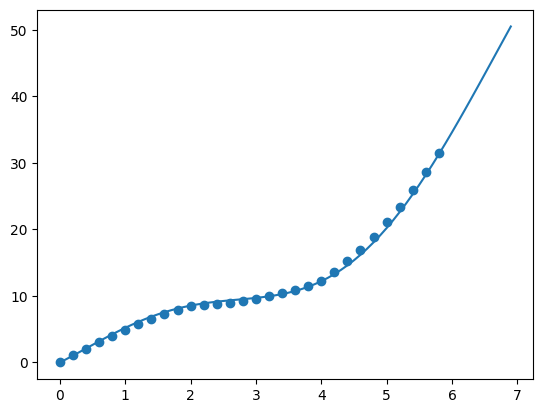

In [10]:
# code
class PolyFitFunction(object):
    def __init__(self, x=None, y=None):
        self.a = (x[0]*(y[2]-y[1]) + x[1]*(y[0]-y[2]) + x[2]*(y[1]-y[0])) / ((x[0]-x[1]) * (x[0]-x[2]) * (x[1]-x[2]))
        self.b = (y[1]-y[0]) / (x[1]-x[0]) - self.a * (x[0]+x[1])
        self.c =  y[0] - self.a * x[0]**2 - self.b * x[0]
        assert len(x) == 3, "must pass x array (three points) to instantiate object"
        assert len(y) == 3, "must pass y array (three points) to instantiate object"

    def __call__(self, x):
        return self.a * x**2 + self.b * x + self.c
    
x_poly = np.arange(0, 6, 0.2)
y_poly = np.zeros(len(x_linear))

for i in range(2):
    x_arr = np.array([x_sparse[i], x_sparse[i+1], x_sparse[i+2]])
    y_arr = np.array([y_sparse[i], y_sparse[i+1], y_sparse[i+2]])
    fit_line = PolyFitFunction(x=x_arr, y=y_arr)

    for j in range(20):
        if y_poly[j+10*i] == 0:
            y_poly[j+10*i] = fit_line(x_poly[j+10*i])
        else:
            y_poly[j+10*i] = (y_poly[j+10*i] + fit_line(x_poly[j+10*i])) / 2
            

plt.plot(x_dense, y_dense)
plt.scatter(x_poly, y_poly)

In [3]:
from scipy.interpolate import interp1d

f_inter = interp1d(x_sparse, y_sparse)

plt.scatter(x_dense, f_inter(x_dense))

ValueError: A value (6.1000000000000005) in x_new is above the interpolation range's maximum value (6).

This error makes perfect sense. We can't interpolate beyond the sparse sampled points

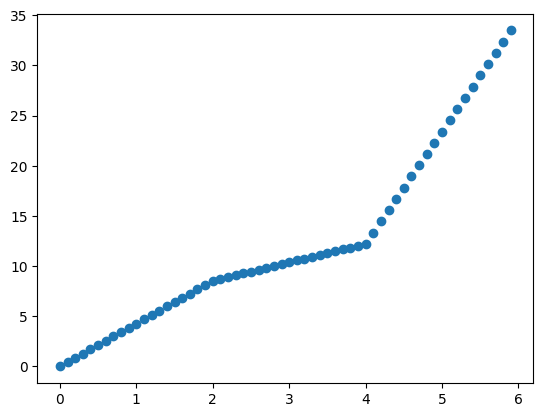

In [11]:
plt.scatter(x_dense[:-10], f_inter(x_dense[:-10]))


Gross, it defaults to linear! Good to know though. We can fix that.

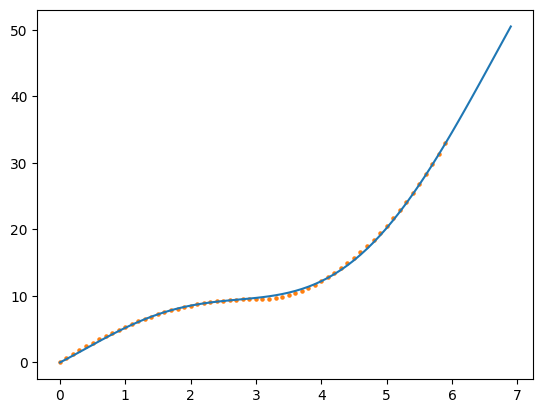

In [12]:
f_inter = interp1d(x_sparse, y_sparse, kind="quadratic")

plt.plot(x_dense, y_dense)
plt.scatter(x_dense[:-10], f_inter(x_dense[:-10]), c="tab:orange", s=5)